In [10]:
import gym
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math

In [77]:
class Model:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(Dense(512, input_dim = self.input_dim, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(self.output_dim, activation = 'linear'))
        model.compile(optimizer = RMSprop(lr = self.lr, rho = 0.95, epsilon = 0.01), loss = "mse", metrics = ['accuracy'])
        return model

class DQNAgent:
    def __init__(self, lr = 2.5e-4, gamma = 0.99, epsilon = 1, decay_coe = 0.99975, min_eps = 0.001, 
                 batch_size = 64, memory_size = 10_000, episodes = 5_000, C = 5):
        
        self.env = gym.make('CartPole-v0')

        self.states = len(env.observation_space.low) 
        self.n_actions = env.action_space.n
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = lr 
        self.gamma = gamma
        self.epsilon = epsilon 
        self.decay_coe = decay_coe
        self.min_eps = min_eps
        self.episodes = episodes
        self.batch_size = batch_size
        self.D = deque(maxlen = memory_size) # replay memory 
        self.C = C
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        
        # Plot data
        self.timestep = self.episodes / 10
        self.history = [] 
        self.reward_data = []
        self.epsilon_data = []
        
        
        
        self.model = Model(self.states, self.n_actions, self.lr)
        # Smooth epsilon 
        self.a = 0.35
        self.b = 0.1
        self.c = 0.01
        
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    
    def decrement_epsilon(self, time):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        cosh = np.cosh(math.exp(-s_time))
        self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))

    def update_D(self, s, a, r, s_, done):
        self.D.append([self.state_shape(s), a, r, self.state_shape(s_), done])
        
    def choose_action(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            action = np.argmax(self.model.Qpolicy.predict(states))
            
        return action
            
    def minibatch(self):
        return random.sample(self.D, self.batch_size)
    
    def graphs(self, episode):
        f1 = plt.figure(1)
        plt.plot([i for i in range(len(self.reward_data))], self.reward_data)
        plt.ylabel('Score per episode')
        plt.xlabel('Episodes')
        plt.savefig(r'RL/reward - e{}v2.png'.format(episode), dpi = 500)
        
        f2 = plt.figure(2)
        plt.plot([i for i in range(len(self.epsilon_data))], self.epsilon_data)
        plt.ylabel('Epsilon')
        plt.xlabel('Episodes')
        plt.savefig(r'RL/epsilon - e{}v2.png'.format(episode), dpi = 500)
        
        f3 = plt.figure(3)
        plt.plot([i for i in range(len(self.history))], self.history)
        plt.ylabel('Loss')
        plt.xlabel('Iterations')
        plt.savefig(r'RL/loss - e{}v2.png'.format(episode), dpi = 500)
        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.D) >= self.batch_size: 
            SARS = self.minibatch()
        
            s = self.state_shape([row[0] for row in SARS])
            qvalue = self.model.Qpolicy.predict(s)[0]

            s_ = self.state_shape([row[3] for row in SARS])
            future_qvalue = self.model.Qtarget.predict(s_)[0]

            for index, (state, action, reward, state_, done) in enumerate(SARS):
                if done == True:
                    Qtarget = reward
                else:
                    Qtarget = reward + self.gamma * np.max(future_qvalue[index])
            
                
                qcurr = qvalue[index][0]
                qcurr[action] = Qtarget                
                X.append(state)
                y.append(qcurr)
                
            X, y = np.array(X).reshape(1,self.batch_size,1,self.states), np.array(y).reshape(1,self.batch_size, 1, self.n_actions)
                                        
            loss = self.model.Qpolicy.fit(X, y, batch_size = self.batch_size, shuffle = False, verbose = 0)
            self.history.append(loss.history['loss'][0])
            
                
            if self.terminal_state:
                self.target_counter+=1

            # C -> target network update frequency
            if self.target_counter > self.C: 
                self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
                self.target_counter = 0 
            
        
    def training(self):
        timestep_reward = 0
        
        for episode in tqdm(range(1, self.episodes+1), ascii = True, unit = 'episode'): 
            s = self.env.reset()
            done = False
            score = 0
            while done != True:
                a = self.choose_action(s)
                
                s_, r, done, _= self.env.step(a)
                
                # Update 
                self.terminal_state = done
                self.update_D(s,a,r,s_,done)
                
                self.train()
                
                s = s_
                score += r
                
            self.decrement_epsilon(episode)  

            # UPDATE
            self.reward_data.append(score)
            self.epsilon_data.append(self.epsilon)
            
            if episode % self.timestep == 0: 
                self.graphs(episode)
            
         
        
        self.graphs(episode)
        self.model.Qpolicy.save(r'RL/{}'.format())
        
    def test(self, model_name,test_episodes = 100):
        model = tf.keras.models.load_model('{}'.format(model_name))
        reward = []
        self.epsilon = 0.05
        for i in range(test_episodes):
            ep_reward = 0
            s = self.env.reset()
            done = False

            while done != True:
                if np.random.random() > self.epsilon: 
                    
                s_, r, done, _ = self.env.step(a)
                
                s = s_
                ep_reward += r
                
            reward.append(ep_reward)
        
        plt.plot([i for i in range(len(reward))], reward)
        plt.xlabel('Episodes')
        plt.ylabel('Episode reward')
        plt.savefig(r'RL/Test.png')

In [78]:
dqn = DQNAgent(episodes = 1_000)

  0%|                                                                            | 1/1000 [00:00<03:37,  4.59episode/s]

100%|#######################################################################| 1000/1000 [5:25:00<00:00, 19.50s/episode]


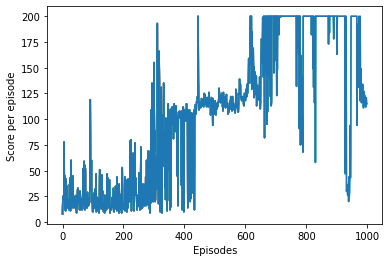

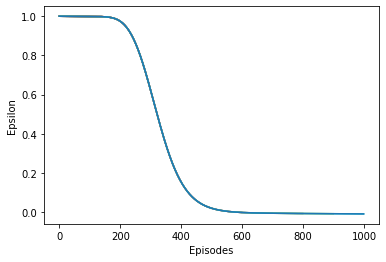

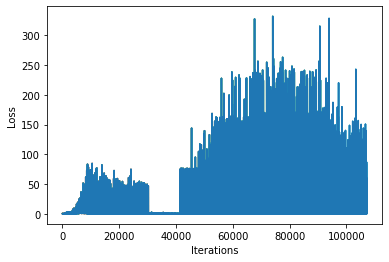

In [79]:
dqn.training()